## TO-DO/BUGS/Considerations

### BUGS

- ECG data has been saved with nan values? when creating a flat list in order to get the mean,std values of the dataset, their values are nan because there are effectively some nan values in the data. This influences on the mean normalization

### TO-DO

- In remove_empty function insert also the ecg case
- Create a general preprocess fuction for both test and train data

### Considerations

- The reconstruction error is significantly lower on the first feature, namely DBP
- L'errore di ricostruzxoine è più affidabile usando la normalizzazione con la media, verificare con i dati dei pazienti sani!!!!!

## Environment setup

In [ ]:
import vitaldb
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed


from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer



## Data load

### API data load

In [ ]:

def load_healthy_API(type='n',n_cases=None):
    caseids_all = vitaldb.find_cases(['ECG_II','ART_DBP','ART_SBP','BT','HR','RR']) # find ids of patient with this parameters
    # Load dataset
    df = pd.read_csv('https://api.vitaldb.net/cases')
    df = df[df['asa'] < 3]

    caseids_unhealthy = df['caseid'].to_numpy() 
    caseids = [el for el in caseids_all if el in caseids_unhealthy]

    if(n_cases is None):
        n_cases = len(caseids)

    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

    if(type in ('a','n','w')):

        if(type in ('a','n')):

            # load all the patients data 
            for i in range(0,n_cases): # Select only five patient for testing purpose; then len(caseids)
                try:
                    vals = vitaldb.load_case(caseids[i], ['ART_DBP','ART_SBP','BT','HR','RR'])
                    dbp.append(vals[:,0])
                    sbp.append(vals[:,1])
                    bt.append(vals[:,2])
                    hr.append(vals[:,3])
                    rr.append(vals[:,4])

                    # extract non-null values
                    dbp[i] = dbp[i][~np.isnan(dbp[i])]  
                    sbp[i] = sbp[i][~np.isnan(sbp[i])] 
                    bt[i] = bt[i][~np.isnan(bt[i])]
                    hr[i] = hr[i][~np.isnan(hr[i])] 
                    rr[i] = rr[i][~np.isnan(rr[i])]

                except Exception as e: 
                    print('\n=================\n')
                    print('INDEX: '+str(i))
                    print('ERROR: '+str(type(e)))
                    print('\n=================\n')
                    pass

        if(type in ('a','w')):
            for i in range(0,n_cases):
                #vals = vitaldb.load_case(caseids[i], ['ECG_II'], 0.01) #parameter 0.01 for a 'zoomed' ecg
                vals = vitaldb.load_case(caseids[i], ['ECG_II'])
                ecg.append(vals[:,0])
    
    return ecg,dbp,sbp,bt,hr,rr



In [ ]:

def load_ills_API(type='n',n_cases=None):
    caseids_all = vitaldb.find_cases(['ECG_II','ART_DBP','ART_SBP','BT','HR','RR']) # find ids of patient with this parameters
    # Load dataset
    df = pd.read_csv('https://api.vitaldb.net/cases')
    df = df[df['asa'] > 3]

    caseids_unhealthy = df['caseid'].to_numpy() 
    caseids = [el for el in caseids_all if el in caseids_unhealthy]

    if(n_cases is None):
        n_cases = len(caseids)

    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

    if(type in ('a','n','w')):

        if(type in ('a','n')):

            # load all the patients data 
            for i in range(0,n_cases): # Select only five patient for testing purpose; then len(caseids)
                try:
                    vals = vitaldb.load_case(caseids[i], ['ART_DBP','ART_SBP','BT','HR','RR'])
                    dbp.append(vals[:,0])
                    sbp.append(vals[:,1])
                    bt.append(vals[:,2])
                    hr.append(vals[:,3])
                    rr.append(vals[:,4])

                    # extract non-null values
                    dbp[i] = dbp[i][~np.isnan(dbp[i])]  
                    sbp[i] = sbp[i][~np.isnan(sbp[i])] 
                    bt[i] = bt[i][~np.isnan(bt[i])]
                    hr[i] = hr[i][~np.isnan(hr[i])] 
                    rr[i] = rr[i][~np.isnan(rr[i])]

                except Exception as e: 
                    print('\n=================\n')
                    print('INDEX: '+str(i))
                    print('ERROR: '+str(type(e)))
                    print('\n=================\n')
                    pass

        if(type in ('a','w')):
            for i in range(0,n_cases):
                #vals = vitaldb.load_case(caseids[i], ['ECG_II'], 0.01) #parameter 0.01 for a 'zoomed' ecg
                vals = vitaldb.load_case(caseids[i], ['ECG_II'])
                ecg.append(vals[:,0])
    
    return ecg,dbp,sbp,bt,hr,rr



### Disk data load

In [ ]:
def load_from_disk(path):
    ecg = []
    dbp = []
    sbp = []
    bt  = []
    hr  = []
    rr  = []

# save the data into a file since loading all the 2k caseids requires at least 1h
    filepath = os.path.join(path,'numeric_data.vitaldb')
    ecgpath = os.path.join(path,'ecg_data.vitaldb')
    #ecgpath = '/Volumes/Windows/SIIA/ecg_data.vitaldb'

    with open(ecgpath, 'rb') as f:
        (ecg) = pickle.load(f)
    with open(filepath, 'rb') as f:
        (dbp,sbp,bt,hr,rr) = pickle.load(f)
    
    return ecg,dbp,sbp,bt,hr,rr

In [ ]:
def save_to_disk(path,ecg,dbp,sbp,bt,hr,rr):
# save the data into a file since loading all the 2k caseids requires at least 1h

    with open(os.path.join(path,'numeric_data.vitaldb'), 'wb') as f:
        pickle.dump((dbp,sbp,bt,hr,rr), f)

    with open(os.path.join(path,'ecg_data.vitaldb'), 'wb') as f:
        pickle.dump(ecg, f)



## save the data into a file since loading all the 2k caseids requires at least 1h
#filepath = '/Users/Roberto/projects/siiaproject-vitanomaly/data.vitaldb'
#ecgpath = '/Volumes/Windows/SIIA/ecg_data.vitaldb'
#ecgpath = '/Users/Roberto/projects/siiaproject-vitanomaly/ecg_data.vitaldb'


### Visualize

In [ ]:
def plot_data(ecg,dbp,sbp,bt,hr,rr,val = None):
    
    if(val == None or not isinstance(val,int)):
        val = np.argmax([len(el) for el in sbp])
    
    plt.figure(figsize=(20,10))
    plt.subplot(611)
    plt.title("ECG")
    plt.plot(ecg[val], color='yellow')
    plt.subplots_adjust(hspace=1.)
    plt.subplot(612)
    plt.title("DBP")
    plt.plot(dbp[val], color='b')
    plt.subplots_adjust(hspace=1.)
    plt.subplot(613)
    plt.title("SBP")
    plt.plot(sbp[val][:], color='r')

    plt.subplot(614)
    plt.title("Body temperature")
    plt.plot(bt[val][:], color='orange')

    plt.subplot(615)
    plt.title("Heart rate")
    plt.plot(hr[val][:], color='r')

    plt.subplot(616)
    plt.title("Respiratory rate")
    plt.plot(rr[val][:], color='g')
    plt.show()

## Preprocessing

In [ ]:
def remove_empty(ecg,dbp,sbp,bt,hr,rr):
# remove empty elements
    try:
        for i in range(0,len(dbp) - len([el for el in dbp if len(el) == 0])):
            if(len(dbp[i])==0):
                dbp.pop(i)
    except:
        pass

    try:
        for i in range(0,len(sbp) - len([el for el in sbp if len(el) == 0])):
            if(len(sbp[i])==0):
                sbp.pop(i)
    except:
        pass

    try:
        for i in range(0,len(bt) - len([el for el in bt if len(el) == 0])):
            if(len(bt[i])==0):
                bt.pop(i)
    except:
        pass

    try:
        for i in range(0,len(hr) - len([el for el in hr if len(el) == 0])):
            if(len(hr[i])==0):
                hr.pop(i)
    except:
        pass

    try:
        for i in range(0,len(rr) - len([el for el in rr if len(el) == 0])):
            if(len(rr[i])==0):
                rr.pop(i)
    except:
        pass

    try:
        for i in range(0,len(ecg) - len([el for el in ecg if len(el) == 0])):
            if(len(ecg[i])==0):
                ecg.pop(i)
    except:
        pass

    return ecg,dbp,sbp,bt,hr,rr



In [ ]:
def minmax_norm(ecg,dbp,sbp,bt,hr,rr):
    old_settings = np.seterr(all='raise')
    idx_remove = []
    for i in range(0,len(ecg)): 
        try:
            #Remove negative values
            ecg[i][np.argwhere(ecg[i]<0)] = np.mean(ecg[i]) 
            # MinMax normalization
            ecg[i] = (ecg[i] - np.min(ecg[i]))/(np.max(ecg[i])-np.min(ecg[i])) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        ecg.pop(idx)

    idx_remove = []
    for i in range(0,len(dbp)): 
        try:
            #Remove negative values
            dbp[i][np.argwhere(dbp[i]<0)] = np.mean(dbp[i]) 
            # MinMax normalization
            dbp[i] = (dbp[i] - np.min(dbp[i]))/(np.max(dbp[i])-np.min(dbp[i])) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        dbp.pop(idx)

    idx_remove = []  
    for i in range(0,len(sbp)): 
        try:
            #Remove negative values
            sbp[i][np.argwhere(sbp[i]<0)] = np.mean(sbp[i]) 
            # MinMax normalization
            sbp[i] = (sbp[i] - np.min(sbp[i]))/(np.max(sbp[i])-np.min(sbp[i])) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        sbp.pop(idx)



    idx_remove = []
    for i in range(0,len(bt)): 
        try:
            #Remove negative values
            bt[i][np.argwhere(bt[i]<0)] = np.mean(bt[i]) 
            # MinMax normalization
            bt[i] = (bt[i] - np.min(bt[i]))/(np.max(bt[i])-np.min(bt[i])) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        bt.pop(idx)



    idx_remove = []
    for i in range(0,len(hr)): 
        try:
            #Remove negative values
            hr[i][np.argwhere(hr[i]<0)] = np.mean(hr[i]) 
            # MinMax normalization
            hr[i] = (hr[i] - np.min(hr[i]))/(np.max(hr[i])-np.min(hr[i])) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        hr.pop(idx)


    idx_remove = []
    for i in range(0,len(rr)): 
        try:
            #Remove negative values
            rr[i][np.argwhere(rr[i]<0)] = np.mean(rr[i]) 
            # MinMax normalization
            rr[i] = (rr[i] - np.min(rr[i]))/(np.max(rr[i])-np.min(rr[i])) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        rr.pop(idx)


    # Back to default settings for errors
    np.seterr(**old_settings)

    return ecg,dbp,sbp,bt,hr,rr

In [23]:
def mean_norm(ecg,dbp,sbp,bt,hr,rr):


    flat_list_ecg = np.asarray([item for sublist in ecg for item in sublist],dtype='float64')
    flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
    flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
    flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
    flat_list_bt = np.asarray([item for sublist in bt  for item in sublist],dtype='float64')
    flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
    #print({'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})


    #ecg_mean,ecg_std = np.mean(flat_list_ecg),np.std(flat_list_ecg)
    dbp_mean,dbp_std = np.mean(flat_list_dbp),np.std(flat_list_dbp)
    sbp_mean,sbp_std = np.mean(flat_list_sbp),np.std(flat_list_sbp)
    bt_mean,bt_std = np.mean(flat_list_bt),np.std(flat_list_bt)
    hr_mean,hr_std = np.mean(flat_list_hr),np.std(flat_list_hr)
    rr_mean,rr_std = np.mean(flat_list_rr),np.std(flat_list_rr)

    print('Mean values for features:\n')
    print({'dbp':dbp_mean,'sbp':sbp_mean,'hr':hr_mean,'bt':bt_mean,'rr':rr_mean})


    old_settings = np.seterr(all='raise')
    idx_remove = []



    #for i in range(0,len(ecg)): 
    #    try:
    #        #Remove negative values
    #        ecg[i][np.argwhere(ecg[i]<0)] = np.mean(ecg[i]) 
    #        # MinMax normalization
    #        ecg[i] = (ecg[i] - ecg_mean)/(ecg_std) 
    #    except: 
    #        # remove values for which the normalization gives Runtime warning
    #        idx_remove.append(i)
#
    #for idx in idx_remove: 
    #    ecg.pop(idx)

    idx_remove = []
    for i in range(0,len(dbp)): 
        try:
            #Remove negative values
            dbp[i][np.argwhere(dbp[i]<0)] = np.mean(dbp[i]) 
            # MinMax normalization
            dbp[i] = (dbp[i] - dbp_mean)/(dbp_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        dbp.pop(idx)

    idx_remove = []  
    for i in range(0,len(sbp)): 
        try:
            #Remove negative values
            sbp[i][np.argwhere(sbp[i]<0)] = np.mean(sbp[i]) 
            # MinMax normalization
            sbp[i] = (sbp[i] - sbp_mean)/(sbp_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        sbp.pop(idx)



    idx_remove = []
    for i in range(0,len(bt)): 
        try:
            #Remove negative values
            bt[i][np.argwhere(bt[i]<0)] = np.mean(bt[i]) 
            # MinMax normalization
            bt[i] = (bt[i] - bt_mean)/(bt_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        bt.pop(idx)



    idx_remove = []
    for i in range(0,len(hr)): 
        try:
            #Remove negative values
            hr[i][np.argwhere(hr[i]<0)] = np.mean(hr[i]) 
            # MinMax normalization
            hr[i] = (hr[i] - hr_mean)/(hr_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        hr.pop(idx)


    idx_remove = []
    for i in range(0,len(rr)): 
        try:
            #Remove negative values
            rr[i][np.argwhere(rr[i]<0)] = np.mean(rr[i]) 
            # MinMax normalization
            rr[i] = (rr[i] - rr_mean)/(rr_std) 
        except: 
            # remove values for which the normalization gives Runtime warning
            idx_remove.append(i)

    for idx in idx_remove: 
        rr.pop(idx)


    # Back to default settings for errors
    np.seterr(**old_settings)

    

    return ecg,dbp,sbp,bt,hr,rr



In [ ]:
def get_preprocessed_data(path, norm = 'mean'):
    ecg,dbp,sbp,bt,hr,rr = load_from_disk(path=path)
    ecg,dbp,sbp,bt,hr,rr = remove_empty(ecg,dbp,sbp,bt,hr,rr)
    if(norm == 'mean'):
        ecg,dbp,sbp,bt,hr,rr = mean_norm(ecg,dbp,sbp,bt,hr,rr )
    elif(norm == 'minmax'): 
        ecg,dbp,sbp,bt,hr,rr = minmax_norm(ecg,dbp,sbp,bt,hr,rr )

    return ecg,dbp,sbp,bt,hr,rr 

In [24]:
norm = 'mean'
func_norm = norm + '_norm'
normalize = globals()[func_norm] # normalize is called later for test data normalization

ecg,dbp,sbp,bt,hr,rr = get_preprocessed_data('/Users/Roberto/projects/AnomalyDetection/data/raw',norm = norm)

Mean values for features:

{'dbp': 59.96132529688496, 'sbp': 111.08083396743335, 'hr': 72.52115204116221, 'bt': 35.30464862834198, 'rr': 15.78349493322607}


In [ ]:
plot_data(ecg,dbp,sbp,bt,hr,rr)

# Autoencoder

## Dense Autoencoder

In [ ]:
flat_list = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
print(flat_list.shape)

In [ ]:
chunks = np.array_split(flat_list,1000)
seq_len = len(chunks[1])

In [ ]:
ntrain = int(len(chunks) * 0.7) # 70% percent of data fro training
max_lenght = max([len(el) for el in chunks])
# Uniform lenghts
X_train = pad_sequences(chunks, max_lenght,padding='post',value=0.5,dtype='float64')
print(np.shape(X_train))

In [ ]:
n_dim = X_train.shape[1]
#input Layer
input_layer = tf.keras.layers.Input(shape=(n_dim,))
#Encoder
encoder = tf.keras.layers.Dense(512, activation="tanh", activity_regularizer=tf.keras.regularizers.l2(0.0005))(input_layer)
encoder=tf.keras.layers.Dropout(0.2)(encoder)
encoder = tf.keras.layers.Dense(256, activation='tanh')(encoder)
encoder = tf.keras.layers.Dense(128, activation='relu')(encoder)
encoder = tf.keras.layers.Dense(64, activation='relu')(encoder)
# Decoder
decoder = tf.keras.layers.Dense(64, activation='relu')(encoder)
decoder = tf.keras.layers.Dense(128, activation='relu')(decoder)
decoder = tf.keras.layers.Dense(256, activation='tanh')(decoder)
decoder=tf.keras.layers.Dropout(0.2)(decoder)
decoder = tf.keras.layers.Dense(512, activation='tanh')(decoder)
decoder = tf.keras.layers.Dense(n_dim, activation='tanh')(decoder)
#Autoencoder
autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
autoencoder.summary()

In [ ]:
autoencoder.fit(X_train,X_train,epochs=15,batch_size=64,validation_split=0.2)

In [ ]:
val_p = vitaldb.load_case(263, ['ART_DBP','ART_SBP','BT','HR','RR'])
test = val_p[:,0]

test = test[~np.isnan(test)] 

print(np.shape(test))

test = test[:seq_len]
test = (test-np.min(test))/(np.max(test)-np.min(test))


res = autoencoder.predict(np.expand_dims(test,axis=0))

print(np.linalg.norm(test,2))
print(np.linalg.norm(res[0],2))
print(abs(np.linalg.norm(test,2)-np.linalg.norm(res[0],2)))

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Original')
plt.plot(test)

plt.subplot(212)
plt.title('Reconstructed')

plt.plot(res[0],scaley=1.)


In [ ]:
# Test on a patient. NB: the data has to be normalized with MinMax approach
#val_p = vitaldb.load_case(17, ['ART_DBP','ART_SBP','BT','HR','RR'])
#
## Pre-processing: remove nan vals, normalize and padding
#val_p = val_p[~np.isnan(val_p)]
#val_p = (val_p-np.min(val_p))/(np.max(val_p)-np.min(val_p))
#test = pad_sequences([val_p],max_lenght,padding='post',value=0.5,dtype='float64')
#
#res = autoencoder.predict(test)
#
## The error for case 464 (ill patient) is much greater than case 17 (healthy patient)
#print(np.linalg.norm(test,2))
#print(np.linalg.norm(res[0],2))
#print(abs(np.linalg.norm(test,2)-np.linalg.norm(res[0],2)))

## LSTM Autoencoder


### Multivariate

In [25]:
TIME_STEP = 6000 # 6000 is the mean length of the dbp time series

flat_list_dbp = np.asarray([item for sublist in dbp for item in sublist],dtype='float64')
flat_list_sbp = np.asarray([item for sublist in sbp for item in sublist],dtype='float64')
flat_list_hr = np.asarray([item for sublist in hr for item in sublist],dtype='float64')
flat_list_bt = np.asarray([item for sublist in bt  for item in sublist],dtype='float64')
flat_list_rr = np.asarray([item for sublist in rr for item in sublist],dtype='float64')
print({'dbp':len(flat_list_dbp),'sbp':len(flat_list_sbp),'hr':len(flat_list_hr),'bt':len(flat_list_bt),'rr':len(flat_list_rr)})

{'dbp': 17738184, 'sbp': 17756137, 'hr': 18369986, 'bt': 15624782, 'rr': 18123465}


In [26]:
X_dbp = []
X_sbp = []
X_bt  = []
X_hr  = []
X_rr  = []

for seq in range(0,len(flat_list_dbp), TIME_STEP):
    X_dbp.append(flat_list_dbp[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_sbp), TIME_STEP):
    X_sbp.append(flat_list_sbp[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_bt), TIME_STEP):
    X_bt.append(flat_list_bt[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hr), TIME_STEP):
    X_hr.append(flat_list_hr[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_rr), TIME_STEP):
    X_rr.append(flat_list_rr[seq:seq+TIME_STEP])


X_dbp = np.asarray(X_dbp,dtype=object)
X_sbp = np.asarray(X_sbp,dtype=object)
X_bt = np.asarray(X_bt,dtype=object)
X_hr = np.asarray(X_hr,dtype=object)
X_rr = np.asarray(X_rr,dtype=object)

X_dbp = pad_sequences(X_dbp, TIME_STEP,padding='post',value = np.mean(flat_list_dbp),dtype='float64')
X_sbp = pad_sequences(X_sbp, TIME_STEP,padding='post',value = np.mean(flat_list_sbp),dtype='float64')
X_rr = pad_sequences(X_rr, TIME_STEP,padding='post',value = np.mean(flat_list_rr),dtype='float64')
X_hr = pad_sequences(X_hr, TIME_STEP,padding='post',value = np.mean(flat_list_hr),dtype='float64')
X_bt = pad_sequences(X_bt, TIME_STEP,padding='post',value = np.mean(flat_list_bt),dtype='float64')

X_dbp = np.asarray(np.expand_dims(X_dbp,axis=2))
X_sbp = np.asarray(np.expand_dims(X_sbp,axis=2))
X_bt = np.asarray(np.expand_dims(X_bt,axis=2))
X_hr = np.asarray(np.expand_dims(X_hr,axis=2))
X_rr = np.asarray(np.expand_dims(X_rr,axis=2))

In [27]:
# Truncate all the values to the min length of the training istances
min_len = np.min([X_dbp.shape[0],X_sbp.shape[0],X_bt.shape[0],X_hr.shape[0],X_rr.shape[0]])

#The remaining values need to be stored for testing
X_dbp = X_dbp[:min_len,:]
X_sbp = X_sbp[:min_len,:]
X_bt = X_bt[:min_len,:]
X_hr = X_hr[:min_len,:]
X_rr = X_rr[:min_len,:]

Y = np.concatenate([X_dbp, X_sbp, X_bt, X_hr, X_rr],axis=2)
X_train = Y[:50,...] # Select the first N instances
print(X_train.shape)

(50, 6000, 5)


In [28]:
batch_size, seq_len, n_features = X_train.shape

In [29]:
model = Sequential()
model.add(LSTM(64, input_shape=(seq_len, n_features),return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(rate=0.1))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6000, 64)          17920     
                                                                 
 dropout_2 (Dropout)         (None, 6000, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, 6000, 32)          12416     
                                                                 
 lstm_2 (LSTM)               (None, 6000, 64)          24832     
                                                                 
 dropout_3 (Dropout)         (None, 6000, 64)          0         
                                                                 
 time_distributed (TimeDistr  (None, 6000, 5)          325       
 ibuted)                                                         
                                                        

In [30]:
history = model.fit(X_train, X_train, epochs=5,shuffle=True,verbose=1)

Epoch 1/5
2/2 [==============================] - 26s 10s/step - loss: 0.4772
Epoch 2/5
2/2 [==============================] - 19s 9s/step - loss: 0.4407
Epoch 3/5
2/2 [==============================] - 21s 11s/step - loss: 0.4068
Epoch 4/5
2/2 [==============================] - 22s 11s/step - loss: 0.3721
Epoch 5/5
2/2 [==============================] - 20s 10s/step - loss: 0.3349


#### Predict

In [61]:
#_,hdbp,hsbp,hbt,hhr,hrr = load_ills_API(n_cases=5)
_,hdbp,hsbp,_,_,_ = load_healthy_API(n_cases=5)
_,hdbp,hsbp,hbt,hhr,hrr = remove_empty(_,hdbp,hsbp,hbt,hhr,hrr)
_,hdbp,hsbp,hbt,hhr,hrr = normalize(_,hdbp,hsbp,hbt,hhr,hrr)
#_,hdbp,hsbp,hbt,hhr,hrr = minmax_norm(_,hdbp,hsbp,hbt,hhr,hrr)

Mean values for features:

{'dbp': 54.28144770791362, 'sbp': 105.65811331424734, 'hr': 1.0287528793065388e-16, 'bt': -5.365660007762615e-16, 'rr': -5.1606928349812934e-17}


In [62]:
flat_list_hdbp = np.asarray([item for sublist in hdbp for item in sublist],dtype='float64')
flat_list_hsbp = np.asarray([item for sublist in hsbp for item in sublist],dtype='float64')
flat_list_hbt = np.asarray([item for sublist in hbt for item in sublist],dtype='float64')
flat_list_hhr = np.asarray([item for sublist in hhr for item in sublist],dtype='float64')
flat_list_hrr = np.asarray([item for sublist in hrr for item in sublist],dtype='float64')

In [63]:
# It's possible to change the time step to the mean of the mean lenghts of the features
TIME_STEP = 6000 # 6000 is the mean length of the dbp time series 

X_dbp = []
X_sbp = []
X_bt = []
X_hr = []
X_rr = []

for seq in range(0,len(flat_list_hdbp), TIME_STEP):
    X_dbp.append(flat_list_hdbp[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hsbp), TIME_STEP):
    X_sbp.append(flat_list_hsbp[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hbt), TIME_STEP):
    X_bt.append(flat_list_hbt[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hhr), TIME_STEP):
    X_hr.append(flat_list_hhr[seq:seq+TIME_STEP])

for seq in range(0,len(flat_list_hrr), TIME_STEP):
    X_rr.append(flat_list_hrr[seq:seq+TIME_STEP])

X_dbp = np.asarray(X_dbp,dtype=object)
X_sbp = np.asarray(X_sbp,dtype=object)
X_bt = np.asarray(X_bt,dtype=object)
X_hr = np.asarray(X_hr,dtype=object)
X_rr = np.asarray(X_rr,dtype=object)


X_dbp = pad_sequences(X_dbp, TIME_STEP,padding='post',value = np.mean(flat_list_hdbp),dtype='float64')
X_sbp = pad_sequences(X_sbp, TIME_STEP,padding='post',value = np.mean(flat_list_hsbp),dtype='float64')
X_bt = pad_sequences(X_bt, TIME_STEP,padding='post',value = np.mean(flat_list_hbt),dtype='float64')
X_hr = pad_sequences(X_hr, TIME_STEP,padding='post',value = np.mean(flat_list_hhr),dtype='float64')
X_rr = pad_sequences(X_rr, TIME_STEP,padding='post',value = np.mean(flat_list_hrr),dtype='float64')


X_dbp = np.asarray(np.expand_dims(X_dbp,axis=2))
X_sbp = np.asarray(np.expand_dims(X_sbp,axis=2))
X_bt = np.asarray(np.expand_dims(X_bt,axis=2))
X_hr = np.asarray(np.expand_dims(X_hr,axis=2))
X_rr = np.asarray(np.expand_dims(X_rr,axis=2))

In [64]:
min_len = np.min([X_dbp.shape[0],X_sbp.shape[0],X_bt.shape[0],X_hr.shape[0],X_rr.shape[0]])

X_dbp = X_dbp[:min_len,:]
X_sbp = X_sbp[:min_len,:]
X_bt = X_bt[:min_len,:]
X_hr = X_hr[:min_len,:]
X_rr = X_rr[:min_len,:]

Y = np.concatenate([X_dbp, X_sbp, X_bt, X_hr, X_rr],axis=2)
X_test = Y[:] # Select the first n instances
print(X_test.shape)

(5, 6000, 5)


In [65]:
res = model.predict(X_test)

1/1 [==============================] - 1s 896ms/step


In [71]:
n_feature = 1
abs(np.linalg.norm(res[...,n_feature]) - np.linalg.norm(X_test[...,n_feature],2))

61.77245713159415

In [67]:
p = 4 # test instance

# Print the reconstruction error for all the features of a given test instance
print('=======================================')
print('\tTest instance ' + str(p))
print('======================================='+'\n')
tot = 0
for i in range(0,5):
    re = np.round(abs(np.linalg.norm(res[p,:,i]) - np.linalg.norm(X_test[p,:,i],2)),3)
    tot = tot + re
    print('Reconstrucion error on feature ' + str(i) + ': ' + \
          str(re)+'\n')
print('Mean reconstruction error: ' + str(np.round(tot/5,3)))


	Test instance 4

Reconstrucion error on feature 0: 25.178

Reconstrucion error on feature 1: 20.375

Reconstrucion error on feature 2: 19.703

Reconstrucion error on feature 3: 26.933

Reconstrucion error on feature 4: 57.11

Mean reconstruction error: 29.86


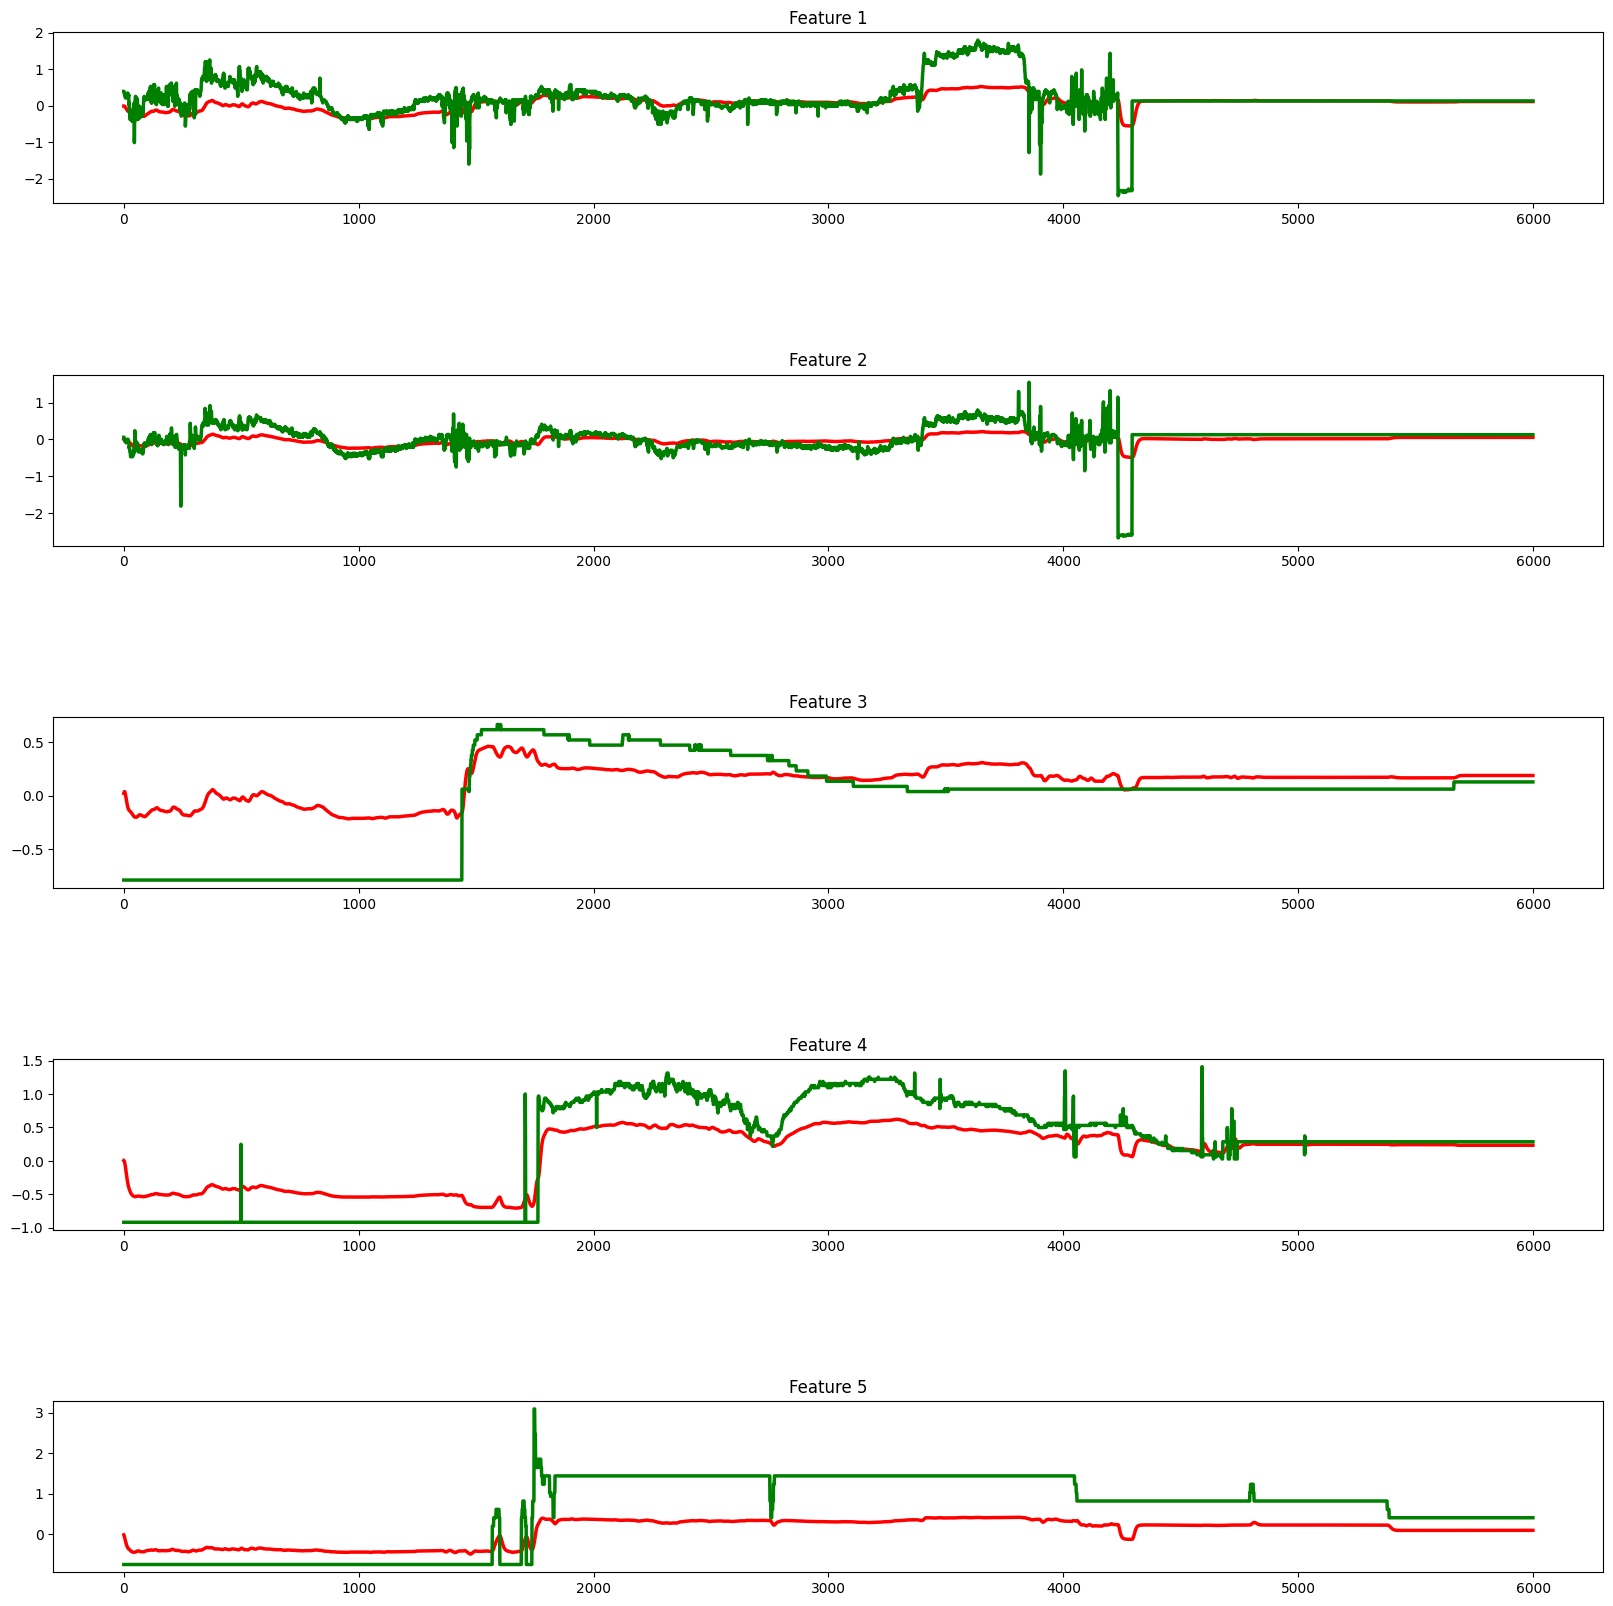

In [68]:
plt.figure(figsize=(20,20))
for i in range(0,5):
    s = '51'+str(i+1)
    plt.subplot(int(s))
    plt.subplots_adjust(hspace=1.)
    plt.title('Feature ' + str(i+1))
    plt.plot(res[p,:,i],'-r',X_test[p,:,i],'-g', linewidth=2.5)

plt.show()

In [73]:
new_ecg = ecg
for i in range(0,len(new_ecg)):
    new_ecg[i] = new_ecg[i][~np.isnan(new_ecg[i])]


In [ ]:
# Back to default settings for errors

old_settings = np.seterr(all='raise')
idx_remove = []
for i in range(0,len(ecg)): 
    try:
        #Remove negative values
        ecg[i][np.argwhere(ecg[i]<0)] = np.mean(ecg[i]) 
        # MinMax normalization
        ecg[i] = (ecg[i] - ecg_mean)/(ecg_std) 
    except: 
        # remove values for which the normalization gives Runtime warning
        idx_remove.append(i)
for idx in idx_remove: 
    ecg.pop(idx)
    
np.seterr(**old_settings)

In [ ]:
# Plot all the feature data

#plt.figure(figsize=(20,10))
#plt.subplot(211)
#plt.plot(res[...,1])
#plt.subplot(212)
#plt.plot(X_test[...,1])
#plt.show()